# Demo: Proposed (*M-CUR) vs RCUR vs BM Tensor on `gray_carvid.mat`

This notebook reproduces the comparison:
- **Proposed** (Tensor *M-CUR)
- **Robust matrix CUR**
- **Tensor BM**
- **SS-SVD**

**Data format:** `.mat` contains a single 3D array with shape `(m, n, p)` = (height, width, frames).


In [26]:
from __future__ import annotations

import time
from pathlib import Path

import numpy as np
from numpy.typing import ArrayLike
import scipy.io as sio
import matplotlib.pyplot as plt
import cv2

import scipy.linalg as la
import scipy.sparse.linalg as spla

from dataclasses import dataclass
from pathlib import Path
from typing import Iterable, Sequence

np.random.seed(0)

# BM

In [27]:
# Helper functions for BM
def fronorm(A: ArrayLike) -> float:
    """Frobenius norm of an array (MATLAB `fronorm`)."""
    A = np.asarray(A)
    return float(np.linalg.norm(A.ravel(order='F')))


def bmp(A: np.ndarray, B: np.ndarray, C: np.ndarray) -> np.ndarray:
    """BMP tensor product (MATLAB `BMP`).

    MATLAB code defines T(i,j,k) = sum_{r=1..ell} A(i,r,k) * B(i,j,r) * C(r,j,k).

    Parameters
    ----------
    A: (m, ell, p)
    B: (m, n, ell)
    C: (ell, n, p)

    Returns
    -------
    T: (m, n, p)
    """
    A = np.asarray(A, dtype=np.float64)
    B = np.asarray(B, dtype=np.float64)
    C = np.asarray(C, dtype=np.float64)

    if A.ndim != 3 or B.ndim != 3 or C.ndim != 3:
        raise ValueError("A,B,C must be 3D arrays")
    m, ell, p = A.shape
    m2, n, ell2 = B.shape
    ell3, n2, p2 = C.shape
    if (m2 != m) or (ell2 != ell) or (ell3 != ell) or (n2 != n) or (p2 != p):
        raise ValueError(
            f"Shape mismatch: A{A.shape}, B{B.shape}, C{C.shape} must satisfy "
            f"B.shape==(m,n,ell), C.shape==(ell,n,p)"
        )

    # einsum: i=r?; A[i,r,k], B[i,j,r], C[r,j,k] -> T[i,j,k]
    return np.einsum('irk,ijr,rjk->ijk', A, B, C, optimize=True)


def bmp_mid_solver(T: np.ndarray, A: np.ndarray, C: np.ndarray, rcond: float | None = None) -> np.ndarray:
    """Least-squares 'middle tensor' solver (MATLAB `BMP_mid_solver`).

    Solves, for each (i,j), the least squares problem:
        H(i,j) * b(i,j) \approx T(i,j,:)
    where H has entries H[k,t] = A[i,t,k] * C[t,j,k].

    Parameters
    ----------
    T: (m, n, p)
    A: (m, ell, p)
    C: (ell, n, p)

    Returns
    -------
    B: (m, n, ell)
    """
    T = np.asarray(T, dtype=np.float64)
    A = np.asarray(A, dtype=np.float64)
    C = np.asarray(C, dtype=np.float64)

    if T.ndim != 3 or A.ndim != 3 or C.ndim != 3:
        raise ValueError("T,A,C must be 3D arrays")

    m, n, p = T.shape
    m2, ell, p2 = A.shape
    ell2, n2, p3 = C.shape
    if (m2 != m) or (p2 != p) or (ell2 != ell) or (n2 != n) or (p3 != p):
        raise ValueError(f"Shape mismatch: T{T.shape}, A{A.shape}, C{C.shape}")

    B = np.zeros((m, n, ell), dtype=np.float64)

    # Solve independently for each (i,j). This matches the MATLAB implementation.
    for i in range(m):
        Ai = A[i, :, :]  # (ell, p)
        for j in range(n):
            Cj = C[:, j, :]  # (ell, p)
            H = (Ai * Cj).T   # (p, ell)
            Vy = T[i, j, :]   # (p,)

            # Minimum-norm least-squares solution (MATLAB lsqminnorm equivalent)
            # np.linalg.lstsq uses SVD and returns the min-norm solution when underdetermined.
            b, *_ = np.linalg.lstsq(H, Vy, rcond=rcond)
            B[i, j, :] = b

    return B


def bmp_als(
    T: np.ndarray,
    A0: np.ndarray,
    B0: np.ndarray,
    C0: np.ndarray,
    tol: float = 1e-5,
    maxit: int = 150,
    verbose: bool = True,
    rcond: float | None = None,
):
    """Alternating Least Squares for BM decomposition (MATLAB `bmp_als`).

    Returns
    -------
    A, B, C, err_list, ediff_list, Xhat
    """
    T = np.asarray(T, dtype=np.float64)
    A = np.asarray(A0, dtype=np.float64).copy()
    B = np.asarray(B0, dtype=np.float64).copy()
    C = np.asarray(C0, dtype=np.float64).copy()

    Xhat = bmp(A, B, C)
    rel_err = fronorm(T - Xhat) / max(fronorm(T), np.finfo(float).eps)
    err = rel_err
    err_list = [rel_err]
    ediff_list = []

    # MATLAB permutations:
    # t  = [2,3,1] -> axes (1,2,0)
    # tt = [3,1,2] -> axes (2,0,1)
    t_axes = (1, 2, 0)
    tt_axes = (2, 0, 1)

    it = 1
    if verbose:
        print(f"Iter={it}; relative error to gt={err}")
    while (err > tol) and (it < maxit):
        X_old = Xhat

        # Holding C,B fixed -> solve for A (via permuted system)
        Ttt = np.transpose(T, tt_axes)
        Ctt = np.transpose(C, tt_axes)
        Btt = np.transpose(B, tt_axes)
        Att = bmp_mid_solver(Ttt, Ctt, Btt, rcond=rcond)
        A = np.transpose(Att, t_axes)

        # Holding A,C fixed -> solve for B
        B = bmp_mid_solver(T, A, C, rcond=rcond)

        # Holding B,A fixed -> solve for C (via permuted system)
        Tt = np.transpose(T, t_axes)
        Bt = np.transpose(B, t_axes)
        At = np.transpose(A, t_axes)
        Ct = bmp_mid_solver(Tt, Bt, At, rcond=rcond)
        C = np.transpose(Ct, tt_axes)

        Xhat = bmp(A, B, C)

        rel_err = fronorm(T - Xhat) / max(fronorm(T), np.finfo(float).eps)
        err_list.append(rel_err)

        err_diff = fronorm(Xhat - X_old) / max(fronorm(X_old), np.finfo(float).eps)
        ediff_list.append(err_diff)
        err = err_diff

        it += 1
        if verbose and (it % 30 == 0):
            print(f"itr={it}; consecutive relative error={err}; relative error to gt={rel_err}")

    return A, B, C, err_list, ediff_list, Xhat


def slice_svd(T: np.ndarray, ell: int):
    """Slice-wise SVD initialization (MATLAB `sliceSVD`).

    Performs SVD on each frontal slice T[:,:,k] and builds factor tensors U,V
    such that each slice is truncated to rank `ell`.

    Returns:
    U, V, sliceS, Tsvd, Tbg, Tfg, svd_err
    """
    T = np.asarray(T, dtype=np.float64)
    if T.ndim != 3:
        raise ValueError("T must be a 3D tensor")

    m, n, p = T.shape
    U_t = np.zeros((m, ell, p), dtype=np.float64)
    V_t = np.zeros((ell, n, p), dtype=np.float64)
    Tsvd = np.zeros((m, n, p), dtype=np.float64)

    q = min(m, n)
    sliceS = np.zeros((q, p), dtype=np.float64)
    svd_err = np.zeros((p,), dtype=np.float64)

    for k in range(p):
        U, s, Vt = np.linalg.svd(T[:, :, k], full_matrices=False)
        sliceS[:, k] = s[:q]
        r = min(ell, len(s))
        # low-rank approximation
        Msvd = U[:, :r] @ (np.diag(s[:r]) @ Vt[:r, :])
        Tsvd[:, :, k] = Msvd
        svd_err[k] = fronorm(T[:, :, k] - Msvd)

        # U slice: left singular vectors * singular values
        U_t[:, :r, k] = U[:, :r] @ np.diag(s[:r])
        # V slice: right singular vectors transposed (ell x n)
        V_t[:r, :, k] = Vt[:r, :]

    # Slice-SVD bg/fg via BMP with Z all-ones
    Z = np.ones((m, n, ell), dtype=np.float64)
    a = 1  # bg component index count in MATLAB
    Tbg = bmp(U_t[:, :a, :], Z[:, :, :a], V_t[:a, :, :])
    Tfg = bmp(U_t[:, a:ell, :], Z[:, :, a:ell], V_t[a:ell, :, :])

    return U_t, V_t, sliceS, Tsvd, Tbg, Tfg, svd_err


# RCUR

Helper functions for RCUR

In [28]:
def shrink(X: np.ndarray, tau: float) -> np.ndarray:
    """Element-wise soft thresholding (MATLAB `shrink_local`)."""
    X = np.asarray(X, dtype=np.float64)
    return np.sign(X) * np.maximum(np.abs(X) - tau, 0.0)


def _spectral_norm(D: np.ndarray) -> float:
    """Largest singular value (2-norm). Uses iterative SVD if large."""
    m, n = D.shape
    # heuristic: use svds when matrix is tall/wide and reasonably sparse-friendly
    if max(m, n) >= 2000 and min(m, n) <= 300:
        try:
            s = spla.svds(D, k=1, which='LM', return_singular_vectors=False)
            return float(np.abs(s[0]))
        except Exception:
            pass
    # fallback
    return float(np.linalg.norm(D, 2))


def rpca_ialm(D: np.ndarray, lambda_: float | None = None, tol: float = 1e-7, max_iter: int = 1000):
    """Robust PCA via Inexact Augmented Lagrange Multiplier (IALM).

    Solves:
        min_{L,S} ||L||_* + lambda * ||S||_1   s.t.  D = L + S

    Parameters
    ----------
    D:
        Data matrix (m,n).
    lambda_:
        Sparse regularization parameter. If None, uses 1/sqrt(max(m,n)).
    tol:
        Relative residual tolerance.
    max_iter:
        Maximum iterations.

    Returns
    -------
    L, S:
        Low-rank and sparse components.
    """
    D = np.asarray(D, dtype=np.float64)
    m, n = D.shape
    if lambda_ is None:
        lambda_ = 1.0 / np.sqrt(max(m, n))

    normD = np.linalg.norm(D, 'fro')
    L = np.zeros_like(D)
    S = np.zeros_like(D)

    norm2 = _spectral_norm(D)
    norm_inf = np.max(np.abs(D))
    denom = max(norm2, norm_inf / max(lambda_, np.finfo(float).eps))
    Y = D / max(denom, np.finfo(float).eps)

    mu = 1.25 / max(norm2, np.finfo(float).eps)
    mu_bar = mu * 1e7
    rho = 1.5

    for _iter in range(1, max_iter + 1):
        # SVD step (nuclear norm proximal)
        U, s, Vt = la.svd(D - S + (1.0 / mu) * Y, full_matrices=False)

        s_shr = np.maximum(s - (1.0 / mu), 0.0)
        r = int(np.sum(s_shr > 0))
        if r == 0:
            L = np.zeros_like(D)
        else:
            L = (U[:, :r] * s_shr[:r]) @ Vt[:r, :]

        # Sparse step (l1 proximal)
        S = shrink(D - L + (1.0 / mu) * Y, lambda_ / mu)

        Z = D - L - S
        Y = Y + mu * Z
        mu = min(mu * rho, mu_bar)

        err = np.linalg.norm(Z, 'fro') / max(normD, np.finfo(float).eps)
        if err < tol:
            break

    return L, S


In [29]:
def run_rcur(
    D: np.ndarray,
    r_rcur: int = 2,
    col_ov_fac: float = 15.0,
    row_ov_fac: float = 25.0,
    max_cols_rcur: int = 120,
    max_rows_rcur: int = 2500,
    lambda_ridge_rcur: float = 1e-2,
    rpca_tol: float = 1e-6,
    rpca_max_iter: int = 500,
    tau_fg_mask: float = 7.5,
    rng: np.random.Generator | None = None,
    verbose: bool = True,
):
    """Run the RCUR baseline as in the MATLAB demo.

    Returns
    -------
    L_bg, S_fg, F_masked, mask, debug
    """
    D = np.asarray(D, dtype=np.float64)
    if D.ndim != 3:
        raise ValueError("D must be a 3D tensor (m,n,p)")

    if rng is None:
        rng = np.random.default_rng(0)

    mD, nD, pD = D.shape
    mn = mD * nD
    Dmat = D.reshape((mn, pD), order='F')

    num_cols = int(np.ceil(col_ov_fac * r_rcur * np.log(pD + 1.0)))
    num_rows = int(np.ceil(row_ov_fac * r_rcur * np.log(mn + 1.0)))
    num_cols = int(min(pD, num_cols, max_cols_rcur))
    num_rows = int(min(mn, num_rows, max_rows_rcur))

    J = rng.permutation(pD)[:num_cols]
    I = rng.permutation(mn)[:num_rows]

    if verbose:
        print(f"RCUR sampling: |I|={num_rows} rows, |J|={num_cols} cols")

    C_tilde = Dmat[:, J]        # (mn, num_cols)
    R_tilde = Dmat[I, :]        # (num_rows, pD)

    lambdaC = 1.0 / np.sqrt(max(C_tilde.shape))
    Chat, _ = rpca_ialm(C_tilde, lambda_=lambdaC, tol=rpca_tol, max_iter=rpca_max_iter)

    lambdaR = 1.0 / np.sqrt(max(R_tilde.shape))
    Rhat, _ = rpca_ialm(R_tilde, lambda_=lambdaR, tol=rpca_tol, max_iter=rpca_max_iter)

    Ucore = Chat[I, :]  # (num_rows, num_cols)

    if lambda_ridge_rcur > 0:
        G = Ucore.T @ Ucore + lambda_ridge_rcur * np.eye(Ucore.shape[1])
        core = la.solve(G, Ucore.T @ Rhat, assume_a='pos')
    else:
        core = la.pinv(Ucore) @ Rhat

    Lhat_mat = Chat @ core  # (mn, pD)

    L_bg = Lhat_mat.reshape((mD, nD, pD), order='F')
    S_fg = D - L_bg
    F_masked, mask = foreground_from_mask(S_fg, D, tau_fg_mask)

    debug = dict(I=I, J=J, Chat=Chat, Rhat=Rhat, core=core)

    return L_bg, S_fg, F_masked, mask, debug

# *M CUR

Helper functions

In [30]:
_MAD_NORM = 0.6744898  # consistent with MATLAB code

def dctmtx(n: int) -> np.ndarray:
    """MATLAB-like dctmtx(n): orthonormal DCT-II matrix."""
    # SciPy's DCT-II with norm='ortho' matches MATLAB's orthonormal DCT matrix.
    from scipy.fftpack import dct
    I = np.eye(n)
    return dct(I, type=2, norm='ortho', axis=0)


def soft_th_mad(R: np.ndarray, tau: float) -> np.ndarray:
    """Frame-wise soft-thresholding with MAD-estimated sigma (MATLAB `soft_th_mad_local`)."""
    R = np.asarray(R, dtype=np.float64)
    if R.ndim != 3:
        raise ValueError("R must be a 3D tensor (m,n,p)")
    m, n, p = R.shape
    S = np.zeros_like(R)
    eps = np.finfo(float).eps
    for k in range(p):
        X = R[:, :, k]
        med = np.median(X)
        sigma = np.median(np.abs(X - med)) / _MAD_NORM
        th = tau * max(sigma, eps)
        S[:, :, k] = np.sign(X) * np.maximum(np.abs(X) - th, 0.0)
    return S


def foreground_from_mask(S_fg: np.ndarray, D: np.ndarray, tau: float):
    """Create foreground mask using MAD threshold (MATLAB `foreground_from_mask_local`)."""
    S_fg = np.asarray(S_fg, dtype=np.float64)
    D = np.asarray(D, dtype=np.float64)
    if S_fg.shape != D.shape:
        raise ValueError("S_fg and D must have the same shape")

    m, n, p = S_fg.shape
    F_masked = np.zeros_like(D)
    M = np.zeros((m, n, p), dtype=bool)
    eps = np.finfo(float).eps

    for k in range(p):
        X = S_fg[:, :, k]
        med = np.median(X)
        sigma = np.median(np.abs(X - med)) / _MAD_NORM
        th = tau * max(sigma, eps)
        Mk = np.abs(X) >= th
        M[:, :, k] = Mk
        F_masked[:, :, k] = D[:, :, k] * Mk.astype(np.float64)

    return F_masked, M


def _top_singular_vectors(Y: np.ndarray, r: int):
    """Compute r leading left/right singular vectors (approx) for a matrix."""
    m, n = Y.shape
    r_use = max(1, min(r, m, n))
    if r_use == 1:
        # svds is sometimes finicky for k=1; handle with fallback
        try:
            u, s, vt = spla.svds(Y, k=1, which='LM')
            # svds returns ascending singular values; for k=1 it's fine
            idx = np.argsort(s)[::-1]
            u = u[:, idx]
            vt = vt[idx, :]
            return u, vt.T
        except Exception:
            pass

    try:
        # use svds to get r_use largest singular vectors
        u, s, vt = spla.svds(Y, k=r_use, which='LM')
        idx = np.argsort(s)[::-1]
        u = u[:, idx]
        vt = vt[idx, :]
        return u, vt.T
    except Exception:
        U, s, Vt = la.svd(Y, full_matrices=False)
        U = U[:, :r_use]
        V = Vt[:r_use, :].T
        return U, V


def select_IJ_by_DEIM_band(Yt: np.ndarray, r_sub: int, r_rows: int, c_cols: int, K: int):
    """Select row/col indices using a DEIM-like pivoted QR (MATLAB `select_IJ_by_DEIM_band_local`)."""
    Yt = np.asarray(Yt, dtype=np.float64)
    if Yt.ndim != 3:
        raise ValueError("Yt must be a 3D tensor (m,n,p)")
    m, n, p = Yt.shape
    K = int(min(K, p))
    Uall = []
    Vall = []

    for k in range(K):
        Yk = Yt[:, :, k]
        Uk, Vk = _top_singular_vectors(Yk, r_sub)
        Uall.append(Uk)
        Vall.append(Vk)

    Uall = np.concatenate(Uall, axis=1) if Uall else np.zeros((m, 0))
    Vall = np.concatenate(Vall, axis=1) if Vall else np.zeros((n, 0))

    # Economy QR (no pivoting)
    QU, _ = np.linalg.qr(Uall, mode='reduced')
    QV, _ = np.linalg.qr(Vall, mode='reduced')

    sI = int(min(r_rows, QU.shape[1]))
    sJ = int(min(c_cols, QV.shape[1]))

    # Pivoted QR on transpose: columns correspond to original rows/cols
    # MATLAB: [~,~,pivU] = qr(QU','vector');
    if sI > 0:
        _, _, pivU = la.qr(QU.T, pivoting=True, mode='economic')
        I = np.sort(pivU[:sI])
    else:
        I = np.array([], dtype=int)

    if sJ > 0:
        _, _, pivV = la.qr(QV.T, pivoting=True, mode='economic')
        J = np.sort(pivV[:sJ])
    else:
        J = np.array([], dtype=int)

    return I, J


def project_CUR_band(Yt: np.ndarray, I: np.ndarray, J: np.ndarray, K: int, lambda_ridge: float, pinv_tol: float):
    """Project tensor slices using CUR with optional ridge (MATLAB `project_CUR_band_local`)."""
    Yt = np.asarray(Yt, dtype=np.float64)
    m, n, p = Yt.shape
    K = int(min(K, p))
    Lt = np.zeros_like(Yt)

    I = np.asarray(I, dtype=int)
    J = np.asarray(J, dtype=int)
    if I.size == 0 or J.size == 0:
        return Lt

    for k in range(K):
        Yk = Yt[:, :, k]
        Ck = Yk[:, J]    # (m, |J|)
        Rk = Yk[I, :]    # (|I|, n)
        Wk = Yk[np.ix_(I, J)]  # (|I|, |J|)

        if lambda_ridge > 0:
            # Uk = (Wk'Wk + λI)^{-1} Wk'
            G = Wk.T @ Wk + lambda_ridge * np.eye(Wk.shape[1])
            Uk = la.solve(G, Wk.T, assume_a='pos', overwrite_a=False, overwrite_b=False)
        else:
            Uk = la.pinv(Wk, rcond=pinv_tol)

        Lt[:, :, k] = Ck @ (Uk @ Rk)

    return Lt

def mode_unfold(A: np.ndarray, k: int | None = None) -> np.ndarray:
    """Mode-k unfolding (matricization).

    Parameters
    ----------
    A:
        d-way tensor as a NumPy array.
    k:
        Mode index (0-based). If None, uses the last dimension.

    Returns
    -------
    A_k:
        Matrix of shape (A.shape[k], prod_{i!=k} A.shape[i]) whose columns are
        the mode-k fibers (MATLAB `modeUnfold` equivalent).
    """
    if k is None:
        k = A.ndim - 1
    if not (0 <= k < A.ndim):
        raise ValueError(f"k must be in [0, {A.ndim-1}], got {k}")

    idx = (k,) + tuple(range(0, k)) + tuple(range(k + 1, A.ndim))
    Ap = np.transpose(A, idx)
    return Ap.reshape((A.shape[k], -1), order='F')


def mode_fold(Ak: np.ndarray, shape: tuple[int, ...], k: int | None = None) -> np.ndarray:
    """Inverse of mode_unfold: fold a matrix back into a tensor.

    Parameters
    ----------
    Ak:
        Unfolded matrix of shape (shape[k], prod_{i!=k} shape[i]).
    shape:
        Target tensor shape.
    k:
        Mode index (0-based). If None, uses the last dimension.

    Returns
    -------
    A:
        Tensor of shape `shape`.
    """
    if k is None:
        k = len(shape) - 1
    if not (0 <= k < len(shape)):
        raise ValueError(f"k must be in [0, {len(shape)-1}], got {k}")

    idx = (k,) + tuple(range(0, k)) + tuple(range(k + 1, len(shape)))
    reshaped = Ak.reshape(tuple(shape[i] for i in idx), order='F')

    # undo permutation
    inv_idx = tuple(range(1, k + 1)) + (0,) + tuple(range(k + 1, len(shape)))
    return np.transpose(reshaped, inv_idx)


def mode_k_mul(A: np.ndarray, M: np.ndarray, k: int) -> np.ndarray:
    """Mode-k product: A x_k M.

    A has shape (..., n_k, ...)
    M has shape (p, n_k)
    Output has shape (..., p, ...)

    This is the NumPy equivalent of MATLAB's `mode3mul_local` when k=2.

    Notes
    -----
    Uses MATLAB-consistent column-major (`order='F'`) reshape semantics.
    """
    if A.ndim < k + 1:
        raise ValueError(f"A.ndim={A.ndim} but k={k}")
    if M.shape[1] != A.shape[k]:
        raise ValueError(f"M.shape[1]={M.shape[1]} must match A.shape[k]={A.shape[k]}")
    out_shape = list(A.shape)
    out_shape[k] = M.shape[0]

    Ak = mode_unfold(A, k)
    Bk = M @ Ak
    return mode_fold(Bk, tuple(out_shape), k)


def mode3mul(Y: np.ndarray, M: np.ndarray) -> np.ndarray:
    """Convenience wrapper for mode-3 multiplication on 3D tensors (k=2)."""
    if Y.ndim != 3:
        raise ValueError("mode3mul expects a 3D tensor (m,n,p)")
    return mode_k_mul(Y, M, k=2)



In [31]:
def run_mcur(
    D: np.ndarray,
    r_sub: int = 10,
    K_low: int = 20,
    row_frac: float = 0.6,
    col_frac: float = 0.6,
    Titer: int = 6,
    tau_mad: float = 0.5,
    tau_fg_mask: float = 7.5,
    lambda_ridge: float = 1e-2,
    pinv_tol: float = 1e-6,
    refresh_every: int = 1,
    rng: np.random.Generator | None = None,
    verbose: bool = True,
):
    """Run the proposed (*M-CUR) algorithm as in the MATLAB demo.

    Returns
    -------
    L_bg, S_fg, F_masked, mask, debug
    """
    D = np.asarray(D, dtype=np.float64)
    if D.ndim != 3:
        raise ValueError("D must be a 3D tensor (m,n,p)")

    mD, nD, pD = D.shape
    B0p = np.median(D, axis=2)
    D0 = D - B0p[:, :, None]

    M_full = dctmtx(pD)
    r_eff = pD
    M = M_full[:r_eff, :]
    Minv = M_full[:, :r_eff]

    L_prop = np.zeros_like(D0)
    S_prop = np.zeros_like(D0)

    I_det = None
    J_det = None
    r_rows = max(20, min(mD, int(round(row_frac * mD))))
    c_cols = max(20, min(nD, int(round(col_frac * nD))))

    for t in range(1, Titer + 1):
        R = D0 - L_prop
        S_prop = soft_th_mad(R, tau_mad)

        Y = D0 - S_prop
        Yt = mode3mul(Y, M)
        K_use = min(K_low, Yt.shape[2])

        if (I_det is None) or (J_det is None) or ((t - 1) % refresh_every == 0):
            I_det, J_det = select_IJ_by_DEIM_band(Yt, r_sub, r_rows, c_cols, K_use)
            if verbose:
                print(f"  DEIM selection (iter {t}): |I|={I_det.size}, |J|={J_det.size}")

        Lt = project_CUR_band(Yt, I_det, J_det, K_use, lambda_ridge, pinv_tol)
        L_prop = mode3mul(Lt, Minv)

        relres = np.linalg.norm((D0 - L_prop - S_prop).ravel()) / max(np.linalg.norm(D0.ravel()), np.finfo(float).eps)
        if verbose:
            print(f"  iter {t}/{Titer}  rel-res={relres:.3e}")

    L_bg = L_prop + B0p[:, :, None]
    S_fg = D - L_bg
    F_masked, mask = foreground_from_mask(S_fg, D, tau_fg_mask)

    debug = dict(B0p=B0p, D0=D0, L_prop=L_prop, S_prop=S_prop, M=M, Minv=Minv, I_det=I_det, J_det=J_det)

    return L_bg, S_fg, F_masked, mask, debug

# Data processing

In [32]:
def covt(X: np.ndarray) -> np.ndarray:
    """Convert a numeric array to uint8 image range [0,255] (MATLAB `covt`).

    Equivalent to: uint8(255 * mat2gray(X)) in MATLAB.

    Parameters
    ----------
    X:
        2D array (or any shape) representing intensities.

    Returns
    -------
    img:
        uint8 array in [0,255].
    """
    X = np.asarray(X, dtype=np.float64)
    xmin = np.min(X)
    xmax = np.max(X)
    if xmax > xmin:
        Y = (X - xmin) / (xmax - xmin)
    else:
        Y = np.zeros_like(X)
    Y = np.clip(Y, 0.0, 1.0)
    return (255.0 * Y).round().astype(np.uint8)


In [33]:
@dataclass(frozen=True)
class VideoMeta:
    """Basic video metadata."""

    path: Path
    fps: float
    total_frames: int
    height: int
    width: int
    channels: int


def probe_video(path: str | Path) -> VideoMeta:
    """Probe video metadata using OpenCV."""
    import cv2

    path = Path(path)
    cap = cv2.VideoCapture(str(path))
    if not cap.isOpened():
        raise RuntimeError(f"Failed to open video: {path}")

    fps = float(cap.get(cv2.CAP_PROP_FPS) or 0.0)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH) or 0)
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT) or 0)

    # Determine channels by reading one frame.
    channels = 0
    ok, frame = cap.read()
    if ok and frame is not None:
        if frame.ndim == 2:
            channels = 1
        else:
            channels = int(frame.shape[2])
    cap.release()

    return VideoMeta(path=path, fps=fps, total_frames=total_frames, height=height, width=width, channels=channels)


def read_video_gray(
    path: str | Path,
    *,
    start: int = 0,
    max_frames: int | None = None,
    stride: int = 1,
    resize: float | None = None,
    verbose: bool = True,
) -> tuple[np.ndarray, float]:
    """Read a video into a grayscale tensor.

    Parameters
    ----------
    path:
        Input video path (e.g. .mp4).
    start:
        Starting frame index (0-based).
    max_frames:
        Maximum number of frames to load (after applying stride). None loads until EOF.
    stride:
        Keep one out of every `stride` frames.
    resize:
        Optional scale factor (e.g. 0.5). If None, no resizing.

    Returns
    -------
    vid:
        Tensor of shape (H, W, P) with dtype float64, values in [0,255].
    fps:
        Frames per second reported by the video file.
    """
    import cv2

    path = Path(path)
    cap = cv2.VideoCapture(str(path))
    if not cap.isOpened():
        raise RuntimeError(f"Failed to open video: {path}")

    fps = float(cap.get(cv2.CAP_PROP_FPS) or 30.0)

    if start > 0:
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(start))

    stride = max(1, int(stride))
    keep_max = None if max_frames is None else max(1, int(max_frames))

    frames: list[np.ndarray] = []
    read_i = 0

    while True:
        ok, frame = cap.read()
        if not ok or frame is None:
            break

        if (read_i % stride) != 0:
            read_i += 1
            continue

        # BGR -> Gray
        if frame.ndim == 3:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        else:
            gray = frame

        if resize is not None and resize != 1.0:
            h, w = gray.shape[:2]
            new_w = max(1, int(round(w * float(resize))))
            new_h = max(1, int(round(h * float(resize))))
            gray = cv2.resize(gray, (new_w, new_h), interpolation=cv2.INTER_AREA)

        frames.append(gray)

        if keep_max is not None and len(frames) >= keep_max:
            break

        read_i += 1

    cap.release()

    if not frames:
        raise RuntimeError(f"No frames read from {path} (start={start}, stride={stride}, max_frames={max_frames})")

    vid = np.stack(frames, axis=2).astype(np.float64)

    if verbose:
        h, w, p = vid.shape
        print(f"Loaded video: {path.name}  shape=[{h} x {w} x {p}]  fps={fps:.3f}")
        if resize is not None:
            print(f"  resize={resize}")
        if stride != 1:
            print(f"  stride={stride}")
        if start != 0:
            print(f"  start={start}")

    return vid, fps


def _tensor_to_uint8_per_frame(X: np.ndarray) -> np.ndarray:
    """Convert (H,W,P) tensor to uint8 using MATLAB-like covt per frame."""
    X = np.asarray(X)
    if X.ndim != 3:
        raise ValueError("Expected a 3D tensor (H,W,P)")

    h, w, p = X.shape
    out = np.empty((h, w, p), dtype=np.uint8)
    for k in range(p):
        out[:, :, k] = covt(X[:, :, k])
    return out


def _mask_to_uint8(M: np.ndarray) -> np.ndarray:
    M = np.asarray(M)
    if M.ndim != 3:
        raise ValueError("Expected a 3D tensor (H,W,P)")
    return (M.astype(np.uint8) * 255)


def save_video_gray(
    X: np.ndarray,
    out_path: str | Path,
    *,
    fps: float = 30.0,
    is_mask: bool = False,
    use_covt: bool = True,
    verbose: bool = True,
):
    """Save a grayscale tensor as an .mp4 video.

    Notes
    -----
    - Many mp4 encoders expect 3-channel frames. We write a stacked RGB version
      of the grayscale frames for compatibility.
    """
    import imageio.v2 as imageio

    out_path = Path(out_path)
    out_path.parent.mkdir(parents=True, exist_ok=True)

    if is_mask:
        frames_u8 = _mask_to_uint8(X)
    else:
        if X.dtype == np.uint8 and not use_covt:
            frames_u8 = X
        else:
            frames_u8 = _tensor_to_uint8_per_frame(X) if use_covt else np.clip(X, 0, 255).astype(np.uint8)

    # libx264 generally requires even frame sizes. If the current size is odd,
    # we crop the last row/col for compatibility.
    h, w, p = frames_u8.shape
    crop_h = (h % 2)
    crop_w = (w % 2)
    if crop_h or crop_w:
        new_h = h - crop_h
        new_w = w - crop_w
        frames_u8 = frames_u8[:new_h, :new_w, :]
        if verbose:
            print(f"[save_video_gray] Cropped to even size: ({h},{w})->({new_h},{new_w})")
        h, w = new_h, new_w

    writer = imageio.get_writer(
        str(out_path),
        fps=float(fps),
        codec="libx264",
        quality=8,
        macro_block_size=None,  # allow arbitrary sizes
    )

    for k in range(p):
        fr = frames_u8[:, :, k]
        rgb = np.stack([fr, fr, fr], axis=2)
        writer.append_data(rgb)

    writer.close()

    if verbose:
        print(f"Saved video: {out_path}  ({p} frames, fps={fps:.3f})")


def save_images(
    X: np.ndarray,
    out_dir: str | Path,
    *,
    prefix: str,
    frame_indices: Sequence[int],
    is_mask: bool = False,
    use_covt: bool = True,
    verbose: bool = True,
):
    """Save selected frames as PNG images."""
    import imageio.v2 as imageio

    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    X = np.asarray(X)
    if X.ndim != 3:
        raise ValueError("Expected a 3D tensor (H,W,P)")

    h, w, p = X.shape

    for idx in frame_indices:
        k = int(idx)
        if not (0 <= k < p):
            continue

        if is_mask:
            fr = (X[:, :, k].astype(np.uint8) * 255)
        else:
            if X.dtype == np.uint8 and not use_covt:
                fr = X[:, :, k]
            else:
                fr = covt(X[:, :, k]) if use_covt else np.clip(X[:, :, k], 0, 255).astype(np.uint8)

        out_path = out_dir / f"{prefix}_{k:04d}.png"
        imageio.imwrite(out_path, fr)

    if verbose:
        print(f"Saved images: {out_dir}  prefix='{prefix}'  n={len(frame_indices)}")


# Demo

In [34]:
plt.rcParams.update({
    "figure.dpi": 120,
    "savefig.dpi": 200,
})

In [65]:
# -----------------------
# Config
# -----------------------
DATA_PATH = "gray_escalator.mat"
FRAME_TO_SHOW = 60   # 1-based frame index
RUN_BM = True        # toggle BM here
ELL = 5              # BM/SS-SVD rank


In [66]:
def load_mat_3d(path: str | Path) -> np.ndarray:
    path = Path(path)
    mat = sio.loadmat(path)
    keys = [k for k in mat.keys() if not k.startswith("__")]
    if not keys:
        raise ValueError(f"No array variable found in {path}")
    arr = mat[keys[0]]
    if arr.ndim != 3:
        raise ValueError(f"Expected 3D array in {path}, got shape {arr.shape}")
    return arr.astype(np.float64)


def clamp_frame_idx(fm_1based: int, p: int) -> tuple[int, int]:
    fm = max(1, min(int(fm_1based), p))
    k = fm - 1
    return fm, k


def pretty_time(s: float | None) -> str:
    if s is None:
        return "—"
    return f"{s:.3f}s"


In [67]:
vid = load_mat_3d(DATA_PATH)/255
m0, n0, p0 = vid.shape
print(f"Loaded vid: [{m0} x {n0} x {p0}]  (m,n,p)")

fm, k = clamp_frame_idx(FRAME_TO_SHOW, p0)
print(f"Displaying frame: {fm} (0-based index {k})")

Loaded vid: [130 x 160 x 200]  (m,n,p)
Displaying frame: 60 (0-based index 59)


In [68]:
def run_bm_and_sssvd(vid: np.ndarray, ell: int = 5, tol: float = 1e-5, maxItr: int = 150, verbose: bool = True):
    # Initialize outputs
    out = dict(
        Tbmd=None, Tsvd=None,
        Tbmd_bg=None, Tbmd_fg=None,
        Tsvd_bg=None, Tsvd_fg=None,
        t_bm=None, t_sssvd=None
    )

    # Permute: MATLAB permute(vid,[1,3,2]) -> (m,p,n)
    T = np.transpose(vid, (0, 2, 1))
    m, p, n = T.shape

    if verbose:
        print("=== Running SS-SVD (sliceSVD init reconstruction) ===")

    t0 = time.time()
    A0, C0, *_ = slice_svd(T, ell)
    B0 = np.ones((m, p, ell), dtype=np.float64)
    Tsvd = bmp(A0, B0, C0)
    out["t_sssvd"] = time.time() - t0

    # BG/FG in permuted domain
    Tsvd_bg = bmp(A0[:, :1, :], B0[:, :, :1], C0[:1, :, :])
    Tsvd_fg = T - Tsvd_bg

    if verbose:
        print(f"SS-SVD done in {out['t_sssvd']:.3f} sec.")

    if verbose:
        print("=== Running BM (ALS refinement) ===")

    t0 = time.time()
    A, B, C, *_ = bmp_als(T, A0, B0, C0, tol=tol, maxit=maxItr, verbose=verbose)
    Tbmd = bmp(A, B, C)
    out["t_bm"] = time.time() - t0

    Tbmd_bg = bmp(A[:, :1, :], B[:, :, :1], C[:1, :, :])
    Tbmd_fg = bmp(A[:, 1:ell, :], B[:, :, 1:ell], C[1:ell, :, :])

    if verbose:
        print(f"BM done in {out['t_bm']:.3f} sec.")

    # Permute back to (m,n,p)
    def back(X): return np.transpose(X, (0, 2, 1))

    out["Tsvd"] = back(Tsvd)
    out["Tbmd"] = back(Tbmd)
    out["Tsvd_bg"] = back(Tsvd_bg)
    out["Tsvd_fg"] = back(Tsvd_fg)
    out["Tbmd_bg"] = back(Tbmd_bg)
    out["Tbmd_fg"] = back(Tbmd_fg)

    return out

In [69]:
bm = dict(
    Tbmd=None, Tsvd=None,
    Tbmd_bg=None, Tbmd_fg=None,
    Tsvd_bg=None, Tsvd_fg=None,
    t_bm=None, t_sssvd=None
)

if RUN_BM:
    bm = run_bm_and_sssvd(vid, ell=ELL, tol=1e-5, maxItr=150, verbose=True)
else:
    print("BM/SS-SVD skipped (RUN_BM=False).")

=== Running SS-SVD (sliceSVD init reconstruction) ===
SS-SVD done in 1.260 sec.
=== Running BM (ALS refinement) ===
Iter=1; relative error to gt=0.08453317736887274
itr=30; consecutive relative error=0.0015167457650006608; relative error to gt=0.060657904791750164
itr=60; consecutive relative error=0.0007793230827935857; relative error to gt=0.058759667613541365
itr=90; consecutive relative error=0.0005126961790971371; relative error to gt=0.05792833660188195
itr=120; consecutive relative error=0.0003500241546049186; relative error to gt=0.057464962267938444
itr=150; consecutive relative error=0.0003022495202435258; relative error to gt=0.057146734589447315
BM done in 590.949 sec.


In [70]:
print("=== Running Proposed (*M-CUR) ===")
t0 = time.time()
L_bg_prop, S_fg_prop, F_masked_prop, _, _ = run_mcur(
    vid,
    r_sub=10,
    K_low=20,
    row_frac=0.6,
    col_frac=0.6,
    Titer=6,
    tau_mad=0.5,
    tau_fg_mask=7.5,
    lambda_ridge=1e-2,
    pinv_tol=1e-6,
    refresh_every=1,
    verbose=True,
)
t_prop = time.time() - t0
print(f"Proposed done in {t_prop:.3f} sec.")

=== Running Proposed (*M-CUR) ===
  DEIM selection (iter 1): |I|=78, |J|=96
  iter 1/6  rel-res=1.124e-01
  DEIM selection (iter 2): |I|=78, |J|=96
  iter 2/6  rel-res=1.162e-01
  DEIM selection (iter 3): |I|=78, |J|=96
  iter 3/6  rel-res=1.210e-01
  DEIM selection (iter 4): |I|=78, |J|=96
  iter 4/6  rel-res=1.233e-01
  DEIM selection (iter 5): |I|=78, |J|=96
  iter 5/6  rel-res=1.269e-01
  DEIM selection (iter 6): |I|=78, |J|=96
  iter 6/6  rel-res=1.281e-01
Proposed done in 4.088 sec.


In [71]:
print("=== Running RCUR (Cai–Hamm–Huang–Needell 2021) ===")
t0 = time.time()
L_bg_rcur, S_fg_rcur, F_masked_rcur, _, _ = run_rcur(
    vid,
    r_rcur=2,
    col_ov_fac=15,
    row_ov_fac=25,
    max_cols_rcur=120,
    max_rows_rcur=2500,
    lambda_ridge_rcur=1e-2,
    rpca_tol=1e-6,
    rpca_max_iter=500,
    tau_fg_mask=7.5,
    rng=np.random.default_rng(0),
    verbose=True,
)
t_rcur = time.time() - t0
print(f"RCUR done in {t_rcur:.3f} sec.")


=== Running RCUR (Cai–Hamm–Huang–Needell 2021) ===
RCUR sampling: |I|=498 rows, |J|=120 cols
RCUR done in 24.352 sec.


In [62]:
def show(ax, img, title):
    ax.imshow(covt(img), cmap="gray", vmin=0, vmax=255)
    ax.set_title(title, fontsize=10)
    ax.axis("off")


def plot_grid(vid, k, bm, L_bg_prop, S_fg_prop, F_masked_prop, L_bg_rcur, S_fg_rcur, F_masked_rcur, #bm: third argument
              t_prop=None, t_rcur=None):
    Tbmd, Tsvd = bm["Tbmd"], bm["Tsvd"]
    Tbmd_bg, Tbmd_fg = bm["Tbmd_bg"], bm["Tbmd_fg"]
    Tsvd_bg, Tsvd_fg = bm["Tsvd_bg"], bm["Tsvd_fg"]
    t_bm, t_sssvd = bm["t_bm"], bm["t_sssvd"]

    plt.figure(figsize=(14, 10))
    plt.suptitle("BM vs SS-SVD vs *M-CUR vs RCUR", fontsize=14)
    # Tbmd = None
    # Tbmd_fg=None
    # Tbmd_bg=None
    # Tsvd = None
    # Tsvd_fg=None
    # Tsvd_bg=None
    # Row 1: reconstructions
    ax = plt.subplot(4, 4, 1); show(ax, vid[:, :, k], "Original")
    ax = plt.subplot(4, 4, 2);
    if Tbmd is not None: show(ax, Tbmd[:, :, k], "BM reconstructed")
    else: ax.axis("off"); ax.set_title("BM reconstructed (skipped)")
    ax = plt.subplot(4, 4, 3);
    if Tsvd is not None: show(ax, Tsvd[:, :, k], "SS-SVD recon")
    else: ax.axis("off"); ax.set_title("SS-SVD recon (skipped)")

    ax = plt.subplot(4, 4, 4); ax.axis("off")
    txt = (
        "Times\n"
        f"Proposed: {pretty_time(t_prop)}\n"
        f"RCUR:     {pretty_time(t_rcur)}\n"
        f"SS-SVD:   {pretty_time(t_sssvd)}\n"
        f"BM(ALS):  {pretty_time(t_bm)}"
    )
    ax.text(0.0, 1.0, txt, fontsize=12, va="top")

    # Row 2: backgrounds
    ax = plt.subplot(4, 4, 5); show(ax, L_bg_prop[:, :, k], "Proposed background")
    ax = plt.subplot(4, 4, 6);
    if Tbmd_bg is not None: show(ax, Tbmd_bg[:, :, k], "BM background")
    else: ax.axis("off"); ax.set_title("BM background (skipped)")
    ax = plt.subplot(4, 4, 7);
    if Tsvd_bg is not None: show(ax, Tsvd_bg[:, :, k], "SS-SVD background")
    else: ax.axis("off"); ax.set_title("SS-SVD background (skipped)")
    ax = plt.subplot(4, 4, 8); show(ax, L_bg_rcur[:, :, k], "RCUR background")

    # Row 3: foregrounds (masked)
    ax = plt.subplot(4, 4, 9); show(ax, F_masked_prop[:, :, k], "Proposed foreground (masked)")
    ax = plt.subplot(4, 4, 10);
    if Tbmd_fg is not None: show(ax, Tbmd_fg[:, :, k], "BM foreground (component)")
    else: ax.axis("off"); ax.set_title("BM foreground (skipped)")
    ax = plt.subplot(4, 4, 11);
    if Tsvd_fg is not None: show(ax, Tsvd_fg[:, :, k], "SS-SVD foreground")
    else: ax.axis("off"); ax.set_title("SS-SVD foreground (skipped)")
    ax = plt.subplot(4, 4, 12); show(ax, F_masked_rcur[:, :, k], "RCUR foreground (masked)")

    # Row 4: raw residual magnitudes
    ax = plt.subplot(4, 4, 13); show(ax, np.abs(S_fg_prop[:, :, k]), "Proposed |S| (raw)")
    ax = plt.subplot(4, 4, 14);
    if Tbmd_fg is not None: show(ax, np.abs(Tbmd_fg[:, :, k]), "BM |FG| (raw)")
    else: ax.axis("off"); ax.set_title("BM |FG| (skipped)")
    ax = plt.subplot(4, 4, 15); show(ax, np.abs(Tsvd_fg[:, :, k]), "SS-SVD |FG| (raw)")
    ax = plt.subplot(4, 4, 16); show(ax, np.abs(S_fg_rcur[:, :, k]), "RCUR |S| (raw)")

    plt.tight_layout()
    plt.show()


# Plot

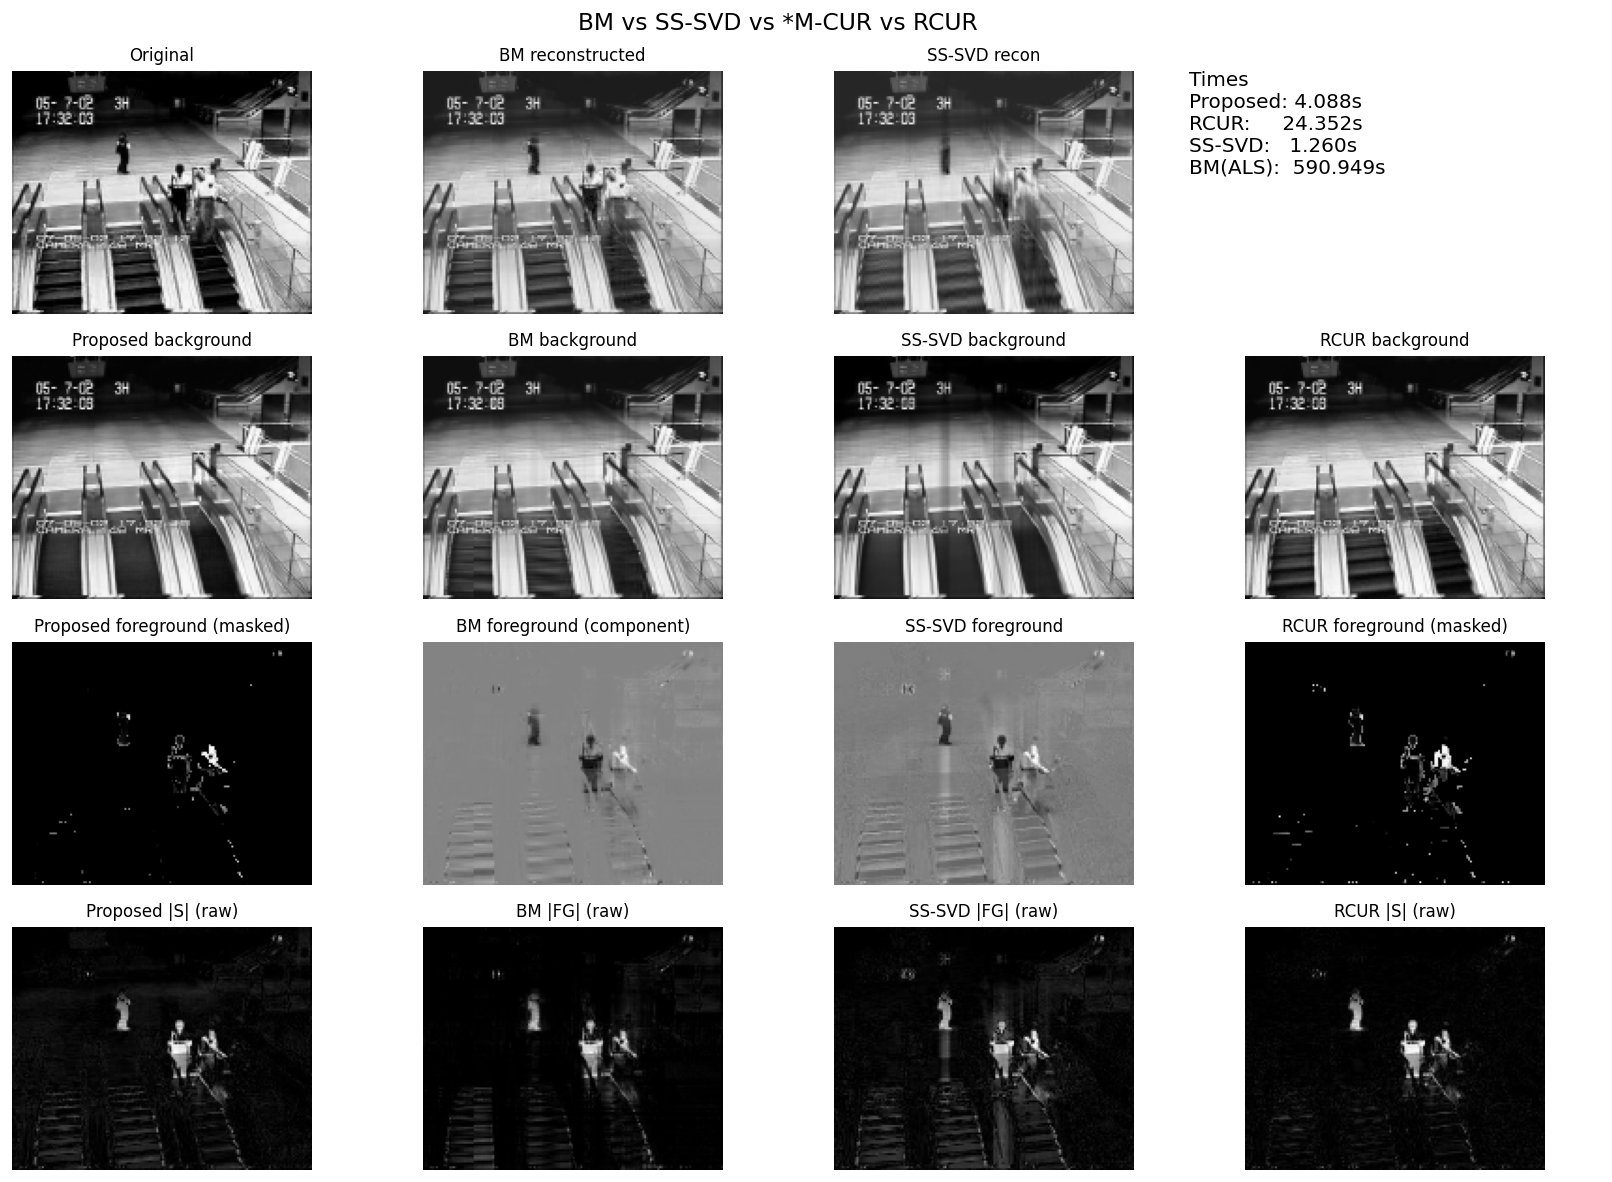

In [72]:
plot_grid(
    vid, k,
    bm=bm,
    L_bg_prop=L_bg_prop,
    S_fg_prop=S_fg_prop, F_masked_prop=F_masked_prop,
    L_bg_rcur=L_bg_rcur, S_fg_rcur=S_fg_rcur, F_masked_rcur=F_masked_rcur,
    t_prop=t_prop, t_rcur=t_rcur
)


In [64]:
import pandas as pd

df = pd.DataFrame([
    {"Method": "Proposed (*M-CUR)", "Time (s)": t_prop},
    {"Method": "RCUR",             "Time (s)": t_rcur},
    {"Method": "SS-SVD",           "Time (s)": bm["t_sssvd"]},
    {"Method": "BM (ALS)",         "Time (s)": bm["t_bm"]},
])

df

,Method,Time (s)
0,Proposed (*M-CUR),3.087795
1,RCUR,19.135766
2,SS-SVD,2.855094
3,BM (ALS),409.326600
